# Indeed job listing data - Exploratory Data Analysis (EDA) 

In [1]:
# Install necessary packages 
#!pip install missingno
#!pip install wordcloud

In [2]:
# Import necessary packages 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from collections import defaultdict

%matplotlib inline

In [3]:
# Constants and configurations

# Ensure NLTK stopwords are downloaded (run this once)
# nltk.download('stopwords')

DATA_PATH = 'output/indeed_jobs_'

In [4]:
# Keyword dictionaries and other configurations 

# Dictionary specifying column names and desired data types
dtype_dict = {
    'page': 'int64',  
    'country': 'string', 
    'job_link': 'object', 
    'search_keyword': 'string', 
    'search_location': 'string', 
    'job_title': 'string', 
    'company_name': 'string', 
    'company_location': 'object', 
    'salary': 'object', 
    'job_description': 'string'
}

# Dictionary of data frames and their corresponding currencies
currency_mapping = {
    'SWE': 'SEK',  # Swedish Krona
    'FRA': 'EUR',  # Euro
    'ITA': 'EUR',  # Euro
    'USA': 'USD'   # US Dollar
}

# Dictionary with common software/programming tools keywords 
software_keywords = {
    'Programming Languages': [
        'python', ' r ', 'sql', 'javascript', 'java', 'c++', 'c#', 'ruby', 'swift', 'kotlin', 'scala', 'matlab', 'sas', 'stata', ' go ', 'php', 'typescript', 'rust', 'bash'
    ],
    'Data Analysis and Manipulation': [
        'excel', 'pandas', 'numpy', 'dplyr', 'tidyverse', 'julia', 'matlab', 'stata'
    ],
    'Machine Learning and Statistical Modeling': [
        'scikit-learn', 'tensorflow', 'keras', 'pytorch', 'xgboost', 'catboost', 'lightgbm', 'mlpack', 'caret', 'mlr', 'weka', 'statsmodels'
    ],
    'Data Visualization and Business Intelligence (BI) Tools': [
        'tableau', 'power bi', 'matplotlib', 'seaborn', 'd3.js', 'looker', 'plotly', 'ggplot2', 'qlik', 'sap', 'looker studio', 'superset', 'metabase'
    ],
    'Big Data Technologies': [
        'spark', 'hadoop', 'bigquery', 'redshift', 'snowflake', 'databricks', 'hive', 'kafka', 'hdfs', 'flink', 'storm'
    ],
    'Database Management Systems (DBMS)': [
        'mysql', 'postgresql', 'mongodb', 'cassandra', 'oracle', 'microsoft sql server', 'firebase', 'db2', 'couchbase', 'neo4j', 'redis', 'couchdb', 'mariadb'
    ],
    'Cloud Computing': [
        'aws', 'azure', 'google cloud', 'gcp', 'ibm cloud', 'oracle cloud', 'digitalocean', 'heroku'
    ],
    'Development Tools': [
        'git', 'docker', 'vscode', 'jupyter', 'pycharm', 'rstudio', 'eclipse', 'netbeans', 'intellij idea', 'notepad++', 'sublime text', 'atom'
    ],
    'Version Control and Collaboration': [
        'github', 'gitlab', 'bitbucket', 'jira', 'confluence', 'slack', 'trello', 'microsoft teams', 'asana', 'notion'
    ],
    'Containerization and Orchestration': [
        'docker', 'kubernetes', 'openshift', 'mesos', 'rancher', 'nomad'
    ],
    'Workflow Management': [
        'airflow', 'luigi', 'prefect', 'kubeflow'
    ],
    'Data Science Platforms': [
        'databricks', 'knime', 'h2o.ai', 'rapidminer', 'datarobot', 'mlflow'
    ]
}

In [5]:
# Helper functions 

# Salary conversion function to handle both thousand separators and decimal points
def convert_salary(value):
    # Converts salary strings with thousand separators or decimal points into a float.
    return float(value.replace('\xa0', '').replace(' ', '').replace(',', '').replace('.', '').replace('..', '.'))

def preprocess_text(text):
    # Remove punctuation and make lowercase
    return re.sub(r'[^\w\s]', '', text.lower())

def tokenize_and_filter(text, stop_words):
    # Tokenization: split text into words and remove stopwords
    tokens = text.split()
    return [word for word in tokens if word not in stop_words]

In [6]:
# High-level functions 

def merge_US_cities(cities):
    '''
    Merges job listings from multiple US cities into a single DataFrame.
    
    Parameters:
    - cities: List of city names (strings) to merge.

    Returns:
    - A DataFrame containing job listings from all specified US cities.
    '''
    
    # Load data for the first city and add the 'country' column manually
    df_NY = pd.read_csv(f"{DATA_PATH}{'USA_'}{cities[0]}.csv")
    df_NY['country'] = 'USA'  # Add the 'country' column to match format
    print("Loaded data for", cities[0])

    # Load data for other cities
    df_LA = pd.read_csv(f"{DATA_PATH}{'USA_'}{cities[1]}.csv")
    df_CHI = pd.read_csv(f"{DATA_PATH}{'USA_'}{cities[2]}.csv")

    # Ensure consistent column order across DataFrames
    desired_order = df_LA.columns.tolist()
    df_NY = df_NY[desired_order]
    print("Column order for consistency:", desired_order)

    # Concatenate the DataFrames
    df_USA = pd.concat([df_NY, df_LA, df_CHI], ignore_index=True)

    # Verify column order consistency 
    assert df_USA.columns.tolist() == desired_order, "Column order mismatch!"

    return df_USA

# unique() prints the unique values, nunique() prints the number of unique values
def check_duplicates(data):
    '''
    # The number of rows should be equal to the number of unique job links, etc 
    '''
    # Get the number of rows 
    num_rows = data.shape[0]
    # Print the number of rows
    print(f'The DataFrame has {num_rows} rows.')
    print(data.nunique()) 
    # Check for duplicates in all columns
    duplicates = data.duplicated(keep=False)
    # Print duplicate rows 
    print(data[duplicates])

def remove_duplicates_jobdesc(data):
    '''
    Checks for duplicate (same job description, location, and job title) in the DataFrame and keep only the latest entry if duplicate is identified. 
    
    Parameters:
    - data: The input DataFrame to check for duplicates.

    Returns:
    - A DataFrame containing with duplicates removed. 
    '''
    # Check if there are any duplicates based on 'job_description', 'location', and 'job_title'
    has_duplicates = data.duplicated(subset=['job_description', 'search_location', 'job_title'], keep=False).any()
    output = pd.DataFrame()
    
    if has_duplicates:
        print("There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.")
        # Below code is only if you want to inspect the duplicated entries  
        # Filter to include only rows with duplicates based on all three columns and sort by 'job_description'
        #output = data[data.duplicated(subset=['job_description', 'search_location', 'job_title'], keep=False)]
        #output = output.sort_values(by=['job_description', 'search_location', 'job_title']).reset_index(drop=True)
        # Display the duplicates
        #print(output)
        # Remove duplicates and keep only the last occurrence
        output = data.drop_duplicates(subset=['job_description', 'search_location', 'job_title'], keep='last').reset_index(drop=True)
    else:
        print("No duplicates found based on 'job_description', 'search_location', and 'job_title'.")
        output = data 
    print(f'Size before: {data.size} Size after removing duplicates: {output.size}')
    return output

In [7]:
# Function for describing categorical data 

def desc_categorical(data):
    #print(data.columns)
    # Get frequency counts for each categorical column
    string_columns = data.select_dtypes(include='string').drop(columns='job_description') # Skip job description! 
    # Get frequency counts for the categorical columns with mixed data types (strings and numbers)
    object_columns = data.select_dtypes(include='object').drop(columns='job_link')

    # Loop through the columns and print value counts
    for col in string_columns.columns:
        print(f'Value counts for column: {col}\n{string_columns[col].value_counts()}\n')
    for col in object_columns.columns:
        print(f'Value counts for column: {col}\n{object_columns[col].value_counts()}\n')

In [8]:
# Functions for extracting salary information 

# Format, clean, and fix columns for salary column 
def clean_columns(data):
    '''
    Describe 
    '''
    # Remove + signs and replace them with spaces in 'search_keyword' and 'search_location'
    data[['search_keyword', 'search_location']] = data[['search_keyword', 'search_location']].replace({r'\+': ' '}, regex=True)
    
    # Remove all newline characters from 'job_description'
    data['job_description'] = data['job_description'].replace({r'\n': ' '}, regex=True)
    
    # Extract salary numbers using regex
    # This regex captures numbers with commas, spaces, and periods, handling both American and European formats
    data['salary'] = data['salary'].astype(str)
    data['salary_num'] = data['salary'].apply(lambda x: re.findall(r'\d{1,3}(?:[,\s]\d{3})*(?:\.\d+)?', x))
    
    # Replace empty lists with NaN in 'salary_num'
    data['salary_num'] = data['salary_num'].apply(lambda x: x if x else np.nan)
    
    # Create 'salary_num_low' and 'salary_num_high' by extracting and cleaning the numbers
    # If there is only one number put it in both low and high column
    data['salary_num_low'] = data['salary_num'].apply(lambda x: convert_salary(x[0]) if isinstance(x, list) and len(x) > 0 else np.nan)
    data['salary_num_high'] = data['salary_num'].apply(lambda x: convert_salary(x[0]) if isinstance(x, list) and len(x) == 1 else convert_salary(x[1]) if isinstance(x, list) and len(x) > 1 else np.nan)

    # Extract time period from 'salary' column using regex
    # par an since 'an' is an English word 
    data['time_period'] = data['salary'].str.extract(r'(hour|year|month|week|day|ora|anno|mese|settimana|giorno|heure|par an|mois|semaine|jour|månad)')

    return data

def convert_salary_to_monthly(row, salary_column):
    '''
    Describe
    '''
    # Dictionary to map time periods (in different languages) to their monthly conversion factor
    time_period_map = {
        'hour': 160, 'ora': 160, 'heure': 160,
        'year': 1/12, 'anno': 1/12, 'par an': 1/12,
        'week': 4, 'settimana': 4, 'semaine': 4,
        'day': 20, 'giorno': 20, 'jour': 20,
        'month': 1, 'mese': 1, 'mois': 1, 'månad': 1
    }
    
    time_period = row['time_period']
    
    # Check if 'time_period' is a valid string and map it to conversion factor, otherwise return NaN
    if isinstance(time_period, str):
        time_period = time_period.lower()
        return row[salary_column] * time_period_map.get(time_period, np.nan)
    
    return np.nan

# Function to apply salary conversion for min and max salary
def apply_salary_conversion(df, currency):
    df['min_salary_month'] = df.apply(lambda row: convert_salary_to_monthly(row, 'salary_num_low'), axis=1)
    df['max_salary_month'] = df.apply(lambda row: convert_salary_to_monthly(row, 'salary_num_high'), axis=1)
    df['currency'] = currency  # Add currency column
    return df

# Function to clean DataFrames, add a currency column, and calculate salary per month
def clean_and_add_currency_and_salaries(df, currency):
    cleaned_df = clean_columns(df)  # Clean the DataFrame
    cleaned_df['currency'] = currency  # Add currency column
    # Calculate min and max salary per month
    cleaned_df['min_salary_month'] = cleaned_df.apply(lambda row: convert_salary_to_monthly(row, 'salary_num_low'), axis=1)
    cleaned_df['max_salary_month'] = cleaned_df.apply(lambda row: convert_salary_to_monthly(row, 'salary_num_high'), axis=1)
    return cleaned_df

In [9]:
# Functions for extracting info from job descriptions 
def extract_keywords(df, country, language):
    '''
    Parameters:
    - df: DataFrame containing job descriptions and search keywords.
    - country: String representing the country to filter by.
    - language: language to filter by (to ensure correct stopwords are removed). 

    Returns:
    - A list with most common keywords? 
    '''
    
    # Always include English stopwords
    stop_words = set(stopwords.words('english'))

    # Add additional stopwords based on the specified language
    if language == 'french':
        stop_words.update(stopwords.words('french'))
    elif language == 'italian':
        stop_words.update(stopwords.words('italian'))
    elif language == 'swedish':
        stop_words.update(stopwords.words('swedish'))
    elif language == 'english':
        # English stopwords are already included at the top
        pass
    else:
        raise ValueError("Unsupported language.")

    # Filter the DataFrame for the specified country
    df_country = df[df['country'] == country].copy()  # Create a copy to avoid SettingWithCopyWarning

    # Use .loc to assign new columns
    df_country.loc[:, 'cleaned_description'] = df_country['job_description'].apply(preprocess_text)
    #df_country.loc[:, 'tokens'] = df_country['cleaned_description'].apply(tokenize_and_filter)
    df_country.loc[:, 'tokens'] = df_country['cleaned_description'].apply(lambda text: tokenize_and_filter(text, stop_words))

    # Flatten the list of tokens and count frequencies
    all_tokens = [token for sublist in df_country['tokens'] for token in sublist]
    word_counts = Counter(all_tokens)

    # Get the top 10 keywords
    common_keywords = word_counts.most_common(10)  
    return (common_keywords, all_tokens)

def plot_common_keywords(common_keywords, country):
    '''
    Plots the most common keywords from job descriptions.

    Parameters:
    - common_keywords: List of tuples (keyword, frequency).
    - country: Name of the country for labeling the plot.
    '''
    # Unzip the list of tuples into two lists: words and counts
    words, counts = zip(*common_keywords)

    # Create a bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(words, counts, color='skyblue')  # Bar plot
    plt.xlabel('Keywords', fontsize=14)  # Label for x-axis
    plt.ylabel('Frequency', fontsize=14)  # Label for y-axis
    plt.title(f'Most Common Keywords in Job Descriptions - {country}', fontsize=16)  # Title of the plot
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to make room for rotated labels
    plt.show()  # Display the plot

def count_keywords(df, country):
    '''
    Counts the occurrences of keywords in job descriptions by category and sub-category for a specific country,
    creating separate entries for each keyword and its associated search keyword.

    Parameters:
    - df: DataFrame containing job descriptions and search keywords.
    - country: String representing the country to filter by.

    Returns:
    - A DataFrame with categories, sub-categories, keyword counts, associated search keywords, and country.
    '''
    # Prepare the DataFrame list to store individual entries
    data = []

    # Filter DataFrame by country
    filtered_df = df[df['country'] == country]
    
    # Flatten the keywords into a single list with their categories
    category_keywords = [(category, keyword) for category, keywords in software_keywords.items() for keyword in keywords]

    for index, row in filtered_df.iterrows():
        job_description = row['job_description'].lower()  # Access job description
        search_keyword = row['search_keyword']  # Access associated search keyword
        
        for category, keyword in category_keywords:
            count = job_description.count(keyword)
            if count > 0:  # Only record non-zero counts
                data.append({
                    'Category': category,
                    'Keyword': keyword,
                    'Count': count,
                    'Search Keyword': search_keyword,
                    'Country': country  
                })

    # Create a df from the collected data
    result_df = pd.DataFrame(data)

    # Group by relevant columns and sum the counts
    result_df = result_df.groupby(['Category', 'Keyword', 'Search Keyword', 'Country'], as_index=False).sum()

    return result_df

In [10]:
# Extract information about interview process (when available)

def extract_stage_text(job_desc, pattern, context_window=100):
    '''
    Extracts text around a matched pattern in the job description.
    
    Parameters:
    - job_desc: String containing the job description.
    - pattern: String or raw string pattern to search for within the job description.
    - context_window: Integer indicating how many characters around the match to capture.
    
    Returns:
    - A string containing text surrounding the matched pattern, or None if no match is found.
    '''
    match = re.search(pattern, job_desc, re.IGNORECASE)
    if match:
        start = max(0, match.start() - context_window)
        end = min(len(job_desc), match.end() + context_window)
        return job_desc[start:end].strip()
    return None

def extract_interview_details(df):
    '''
    Extracts detailed information for all interview stages from job descriptions and creates both a DataFrame 
    with the extracted text and a Boolean indicator DataFrame.
    
    Parameters:
    - df: DataFrame containing job listings.
    
    Returns:
    - Tuple of DataFrames:
        - Detailed text DataFrame for each category.
        - Boolean indicator DataFrame showing True/False for the presence of each category.
    '''
    # Define patterns for each interview stage
    stages = {
        'case_study': r'case study|take-home assignment|assessment project',
        'coding_assessment': r'coding test|coding interview|programming assessment|technical assessment|live coding challenge',
        'phone_screening': r'phone screening|phone interview|screening call',
        'on_site_interview': r'on-site interview|final round|in-person interview',
        'presentation': r'presentation|project presentation|technical presentation'
    }
    
    # Initialize lists to store extracted details and indicators
    interview_info = []
    interview_flags = []

    for _, row in df.iterrows():
        job_desc = row['job_description']
        
        # Store detailed text and flags for each stage in dictionaries
        details = {'job_id': row['job_id']}
        flags = {'job_id': row['job_id']}
        # Add also job title or url here to verify if there are duplicates 
        
        for stage, pattern in stages.items():
            extracted_text = extract_stage_text(job_desc, pattern)
            details[f'{stage}_text'] = extracted_text
            flags[stage] = bool(extracted_text)
        
        interview_info.append(details)
        interview_flags.append(flags)

    # Convert the lists of dictionaries into DataFrames
    interview_info_df = pd.DataFrame(interview_info)
    interview_flags_df = pd.DataFrame(interview_flags)

    return interview_info_df, interview_flags_df

## Load the data
Import the data scraped using scraper-countries.py (Sept 20-21 2024), for the following countries: USA, Sweden, France, and Italy. These datasets contain the job listings for the 3 largest cities in respective country, for the job titles _Data Scientist_, _Data Analyst_, _Product Analyst_, and _BI Analyst_.

In [11]:
# Import csv files with scraped data for resp. country 
# Sweden 
df_SWE = pd.read_csv(f"{DATA_PATH}{'Sweden'}.csv")
# France 
df_FRA = pd.read_csv(f"{DATA_PATH}{'France'}.csv")
# Italy
df_ITA =pd.read_csv(f"{DATA_PATH}{'Italy'}.csv")

In [12]:
# USA 
df_USA = merge_US_cities(['NY', 'LA', 'CHI'])

Loaded data for NY
Column order for consistency: ['page', 'country', 'job_link', 'search_keyword', 'search_location', 'job_title', 'company_name', 'company_location', 'salary', 'job_description']


## Initial inspection of the data

In [13]:
df_SWE.head(5)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data+Analyst,Stockholm,Data Analyst (Data Visualization),Swedium Global Services,Distansjobb in Stockholm,Not available,Data Analyst (Data Visualization) \n \n Swediu...
1,1,Sweden,https://se.indeed.com/rc/clk?jk=5dbbee34feadd8...,Data+Analyst,Stockholm,Data Analyst,Deploja AB,169 73 Solna,Not available,Role: \n \n Website Performance: Web analyst f...
2,1,Sweden,https://se.indeed.com/rc/clk?jk=07cc3fa43334c5...,Data+Analyst,Stockholm,Data Analyst,Cubane Solutions AB,Stockholm,Heltid,Responsibilities \n \n Website Performance: W...
3,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data+Analyst,Stockholm,Data Analyst,Sobi,Stockholm,Heltid,Company Description \n Statistics show that w...
4,1,Sweden,https://se.indeed.com/rc/clk?jk=65bfa8c313624f...,Data+Analyst,Stockholm,"Juniora Analysts till Operations, Engineering,...",Deloitte,113 57 Stockholm,Heltid,Företagsbeskrivning \n \n \n Deloitte är en g...


In [14]:
df_FRA.head(5)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,France,https://www.indeed.fr/rc/clk?jk=3163cc1d8a51ee...,Data+Analyst,Paris (75),CDI - Data analyst KYC - Senior F/H,La Banque Postale,Paris (75),CDI,INTRODUCTION \n Au sein de la direction Data ...
1,1,France,https://www.indeed.fr/rc/clk?jk=71fa252714d41c...,Data+Analyst,Paris (75),Data Analyst F/H,IZI Solutions Durables,Télétravail partiel à La Défense (92),CDI,"À propos \n \n En 2019, le Groupe EDF veut re..."
2,1,France,https://www.indeed.fr/rc/clk?jk=21f25c16a32522...,Data+Analyst,Paris (75),Data analyst,Le Groupe La Poste,Issy-les-Moulineaux (92),CDI,"La Poste Groupe change, nos métiers évoluent. ..."
3,1,France,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,Paris (75),Data Analyst H/F,GROUPE ID SEARCH,Paris (75),"À partir de 35 000 € par an - CDI, Temps plein","Tertialis, société du groupe ID SEARCH, est sp..."
4,1,France,https://www.indeed.fr/rc/clk?jk=8c5cc311877c09...,Data+Analyst,Paris (75),Consultant Débutant Data Analyst en CDI - Pari...,EY,92037 La Défense,CDI,Participer à la digitalisation de nos clients ...


In [15]:
df_ITA.head(5)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Business Intelligence (Power BI) - Python- Bus...,Area IT Group,"Roma, Lazio",25.000 € - 40.000 € all'anno,Ricerchiamo Sviluppatori in almeno uno dei seg...
1,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Power Bi Analyst,Verisure Italy,00144 Roma,Not available,Ti piacerebbe far parte della multinazionale d...
2,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",IT Project Management Internship,Procter & Gamble,"Roma, Lazio",Not available,Job Location Rome Job Description INFORMATI...
3,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Credit & Collection Data Analyst,Verisure Italy S R L,00144 Roma,Not available,Ti piacerebbe far parte della multinazionale d...
4,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Aeronautical System Analyst,adecco,"Roma, Lazio",Not available,Per azienda leader a livello globale nella ges...


In [16]:
df_USA.head(5)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,USA,https://www.indeed.com/rc/clk?jk=5bf7eb172149d...,Data+Analyst,"New+York, NY",Business Analyst (Data products),Aon,"Remote in New York, NY","$80,000 - $95,000 a year - Full-time","Senior Associate Consultant, Data Solutions ..."
1,1,USA,https://www.indeed.com/rc/clk?jk=6b99bd10f1316...,Data+Analyst,"New+York, NY",Data Analyst,NYU Langone,"New York, NY",$32.38 - $39.01 an hour - Temporary,NYU Grossman School of Medicine is one of the...
2,1,USA,https://www.indeed.com/rc/clk?jk=d70c515431fa2...,Data+Analyst,"New+York, NY",Data Analyst,NYU Langone Health,"New York, NY 10016","$67,771.14 - $75,000.00 a year - Full-time",NYU Grossman School of Medicine is one of the...
3,1,USA,https://www.indeed.com/rc/clk?jk=3aa26222eadd6...,Data+Analyst,"New+York, NY","Resy Marketing Data Analyst, Data and Analytics",Amex,"Hybrid work in New York, NY","$60,000 - $110,000 a year",You Lead the Way. We’ve Got Your Back. \n With...
4,1,USA,https://www.indeed.com/rc/clk?jk=3aa564ce173c8...,Data+Analyst,"New+York, NY",2025 University Graduate - Digital Strategy An...,Adobe,"New York, NY 10012","$53,900 - $101,450 a year - Full-time",Our Company Changing the world through digit...


### Check dimensions and data types

In [17]:
# Check dimensions of dfs 
print(f'SWE \t   columns: {df_SWE.shape[1]} \t  rows: {df_SWE.shape[0]}')
print(f'FRA \t   columns: {df_FRA.shape[1]} \t  rows: {df_FRA.shape[0]}')
print(f'ITA \t   columns: {df_ITA.shape[1]} \t  rows: {df_ITA.shape[0]}')
print(f'USA \t   columns: {df_USA.shape[1]} \t  rows: {df_USA.shape[0]}')

SWE 	   columns: 10 	  rows: 320
FRA 	   columns: 10 	  rows: 2200
ITA 	   columns: 10 	  rows: 769
USA 	   columns: 10 	  rows: 1317


In [18]:
# Check data types
df_SWE.info() 
# Most columns are of type 'Dtype object'
# Convert columns with strings only to string data type to optimize performance
# Mixed columns with both numbers and strings: company_location, salary, job_link (url) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   page              320 non-null    int64 
 1   country           320 non-null    object
 2   job_link          320 non-null    object
 3   search_keyword    320 non-null    object
 4   search_location   320 non-null    object
 5   job_title         320 non-null    object
 6   company_name      320 non-null    object
 7   company_location  320 non-null    object
 8   salary            320 non-null    object
 9   job_description   320 non-null    object
dtypes: int64(1), object(9)
memory usage: 25.1+ KB


In [19]:
# Convert objects to strings 
df_SWE = df_SWE.astype(dtype_dict)

# Output new data types
print(df_SWE.dtypes) # Is string[python] not dtype string?

page                         int64
country             string[python]
job_link                    object
search_keyword      string[python]
search_location     string[python]
job_title           string[python]
company_name        string[python]
company_location            object
salary                      object
job_description     string[python]
dtype: object


In [20]:
# Do the same for the other datasets 
df_FRA = df_FRA.astype(dtype_dict)
df_ITA = df_ITA.astype(dtype_dict)
df_USA = df_USA.astype(dtype_dict)

### Conclusions
- The following columns needs to be cleaned: search_keyword, job_title, job_description, company_location.   
- The salary column should be split into two columns (separate numeric vs string content).    

## Data reduction and data cleaning
Handle missing and duplicate data entries. Remove unnecessary columns (if any). 
Clean and preprocess the data to handle anomalies and outliers. 

### Missing values

In [21]:
# The scraper labels cells as 'Not available' when there is no value. Change these to NaN. 
df_SWE.replace('Not available', np.NaN, inplace=True)
df_FRA.replace('Not available', np.NaN, inplace=True) 
df_ITA.replace('Not available', np.NaN, inplace=True)
df_USA.replace('Not available', np.NaN, inplace=True)

df_FRA.isnull().sum() # Missing salary and job description entries 
df_SWE.isnull().sum() # Missing salary entries 
df_ITA.isnull().sum() # Missing salary entries 
df_USA.isnull().sum() # Missing salary entries 

# Calculate percentage of missing values
df_FRA.isnull().mean() * 100

# Salary entries will be examined later when columns are split 
# For now we do not drop these rows (we are not primarily interested in salaries)

page                 0.000000
country              0.000000
job_link             0.000000
search_keyword       0.000000
search_location      0.000000
job_title            0.000000
company_name         0.000000
company_location     0.000000
salary              17.181818
job_description      2.318182
dtype: float64

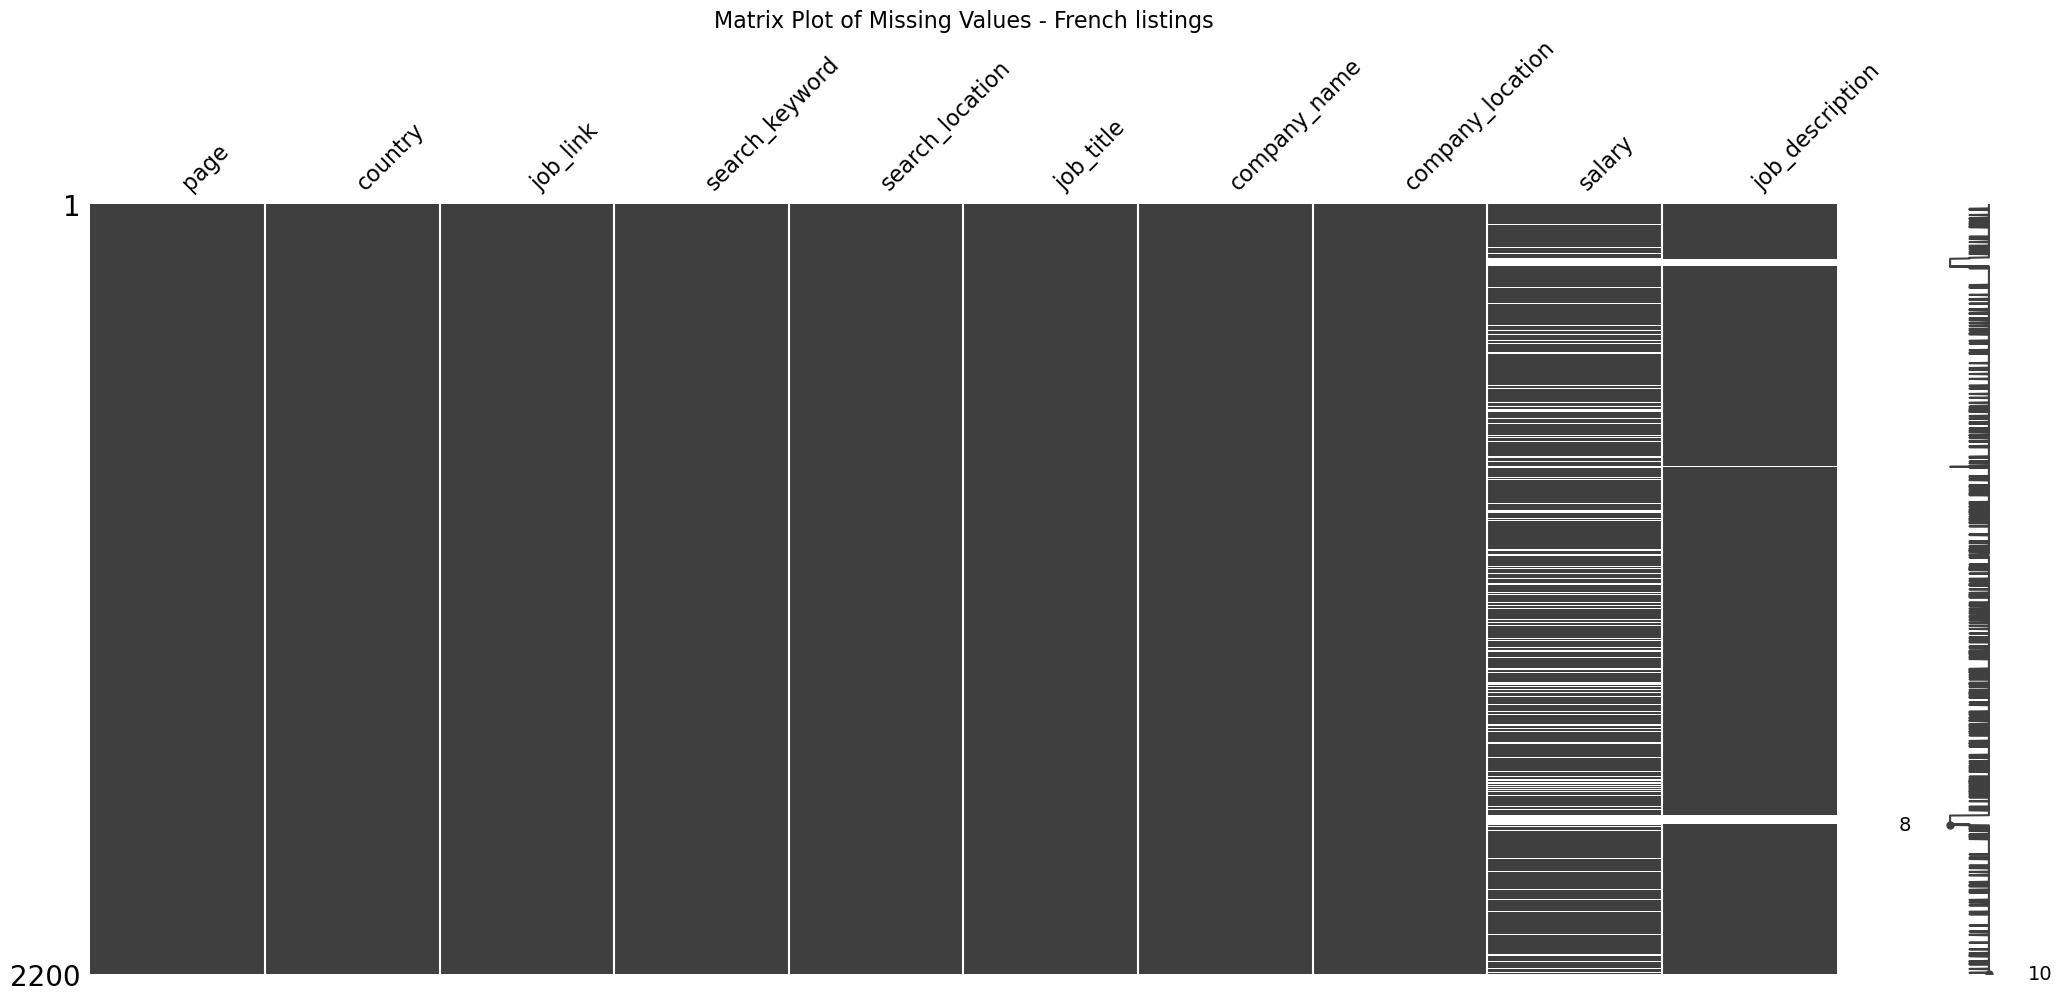

In [22]:
# Visualize missing data patterns using missingno
msno.matrix(df_FRA) #.sample(250)
plt.title('Matrix Plot of Missing Values - French listings', fontsize=16)  # Add a title to the plot
plt.show()

In [23]:
# Look into the missing descriptions for French job listings (seems that requests were blocked here?)
print(df_FRA.isnull().sum())
#df_FRA[df_FRA['job_description'].isnull()]

# Manual imports of missing job descriptions from URLs 
df_FRA_missing = pd.read_csv('df_FRA_missing_data.csv')

page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description      51
dtype: int64


In [24]:
# Merge the DataFrames based on the 'job_link' column
merged_df = pd.merge(df_FRA, df_FRA_missing, on=['job_link'])
merged_df = pd.merge(df_FRA, df_FRA_missing[['job_link', 'job_description_new']], on='job_link', how='left')
# Save the job description as only one column (based on when it is not NaN)
merged_df['job_description'] = merged_df['job_description'].combine_first(merged_df['job_description_new'])
merged_df.drop('job_description_new', axis=1, inplace=True)
# Verify that there are no missing values in job_description now
merged_df

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,France,https://www.indeed.fr/rc/clk?jk=3163cc1d8a51ee...,Data+Analyst,Paris (75),CDI - Data analyst KYC - Senior F/H,La Banque Postale,Paris (75),CDI,INTRODUCTION \n Au sein de la direction Data ...
1,1,France,https://www.indeed.fr/rc/clk?jk=71fa252714d41c...,Data+Analyst,Paris (75),Data Analyst F/H,IZI Solutions Durables,Télétravail partiel à La Défense (92),CDI,"À propos \n \n En 2019, le Groupe EDF veut re..."
2,1,France,https://www.indeed.fr/rc/clk?jk=21f25c16a32522...,Data+Analyst,Paris (75),Data analyst,Le Groupe La Poste,Issy-les-Moulineaux (92),CDI,"La Poste Groupe change, nos métiers évoluent. ..."
3,1,France,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,Paris (75),Data Analyst H/F,GROUPE ID SEARCH,Paris (75),"À partir de 35 000 € par an - CDI, Temps plein","Tertialis, société du groupe ID SEARCH, est sp..."
4,1,France,https://www.indeed.fr/rc/clk?jk=8c5cc311877c09...,Data+Analyst,Paris (75),Consultant Débutant Data Analyst en CDI - Pari...,EY,92037 La Défense,CDI,Participer à la digitalisation de nos clients ...
...,...,...,...,...,...,...,...,...,...,...
2195,3,France,https://www.indeed.fr/rc/clk?jk=e140c6dba19957...,BI+Analyst,Lyon (69),COMMERCIAL PERFORMANCE DATA OWNER H/F,Groupe Seb,Écully (69),NaN,Minimum annual compensation (individual bonuse...
2196,4,France,https://www.indeed.fr/rc/clk?jk=02f3391fc923b2...,BI+Analyst,Lyon (69),Consultant en Gestion et Gouvernance de l'info...,Eowin,Lyon (69),"CDI, Temps plein",Fort de plus de 30 ans d’expérience dans la ge...
2197,4,France,https://www.indeed.fr/rc/clk?jk=9761f99e5e5999...,BI+Analyst,Lyon (69),DevOps (H/F),Askills,Lyon (69),"CDI, Temps plein",Askills est un jeune cabinet de conseil lyonna...
2198,4,France,https://www.indeed.fr/rc/clk?jk=76d98e1171c985...,BI+Analyst,Lyon (69),Tech Lead H/F,Sogeti,Lyon (69),CDI,Description de l'entreprise \n \n \n SOGETI c'...


In [25]:
merged_df.isnull().sum()
df_FRA = merged_df
print(df_FRA.isnull().sum())

page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description       0
dtype: int64


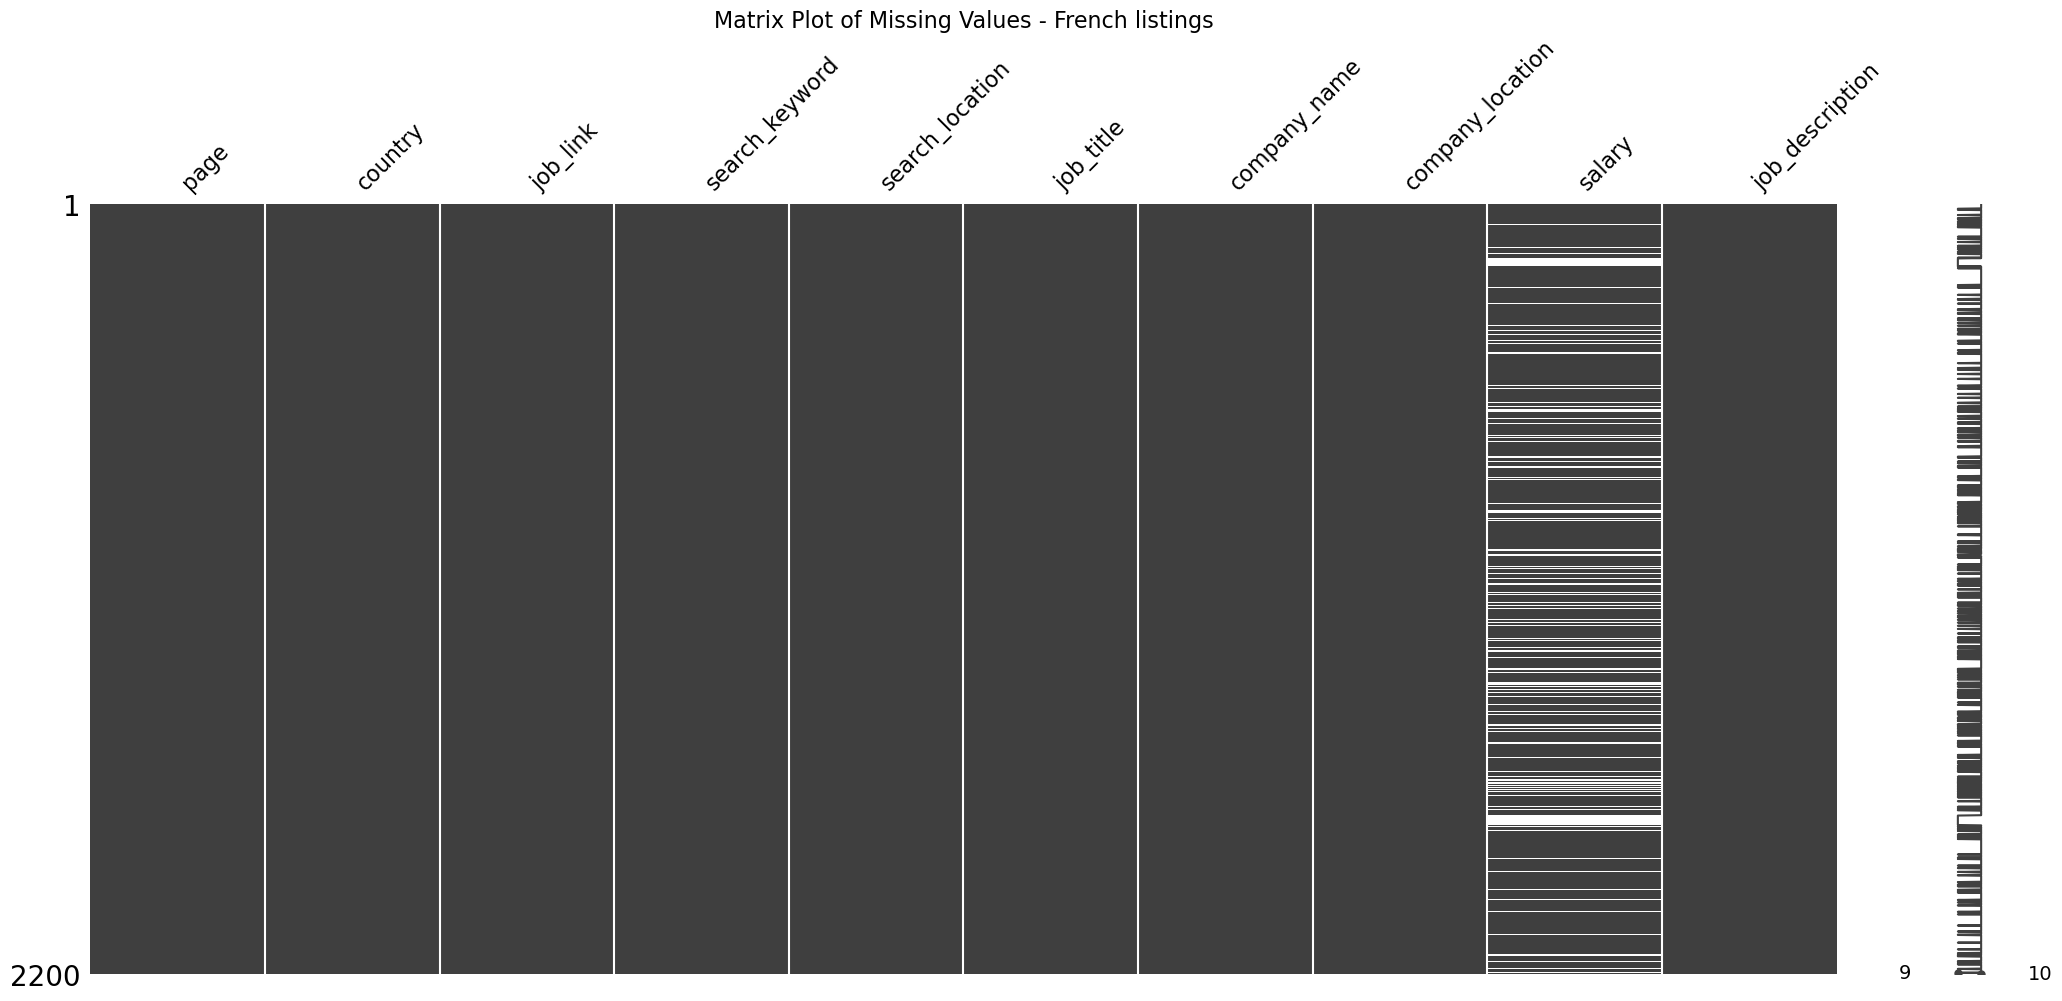

In [26]:
# Now the job_description should not have missing values anymore
msno.matrix(df_FRA) #.sample(250)
plt.title('Matrix Plot of Missing Values - French listings', fontsize=16)  
plt.show()

In [27]:
# Make sure all data types are the same after adding info from CSV
df_FRA = df_FRA.astype(dtype_dict)
print(df_FRA.dtypes)

page                         int64
country             string[python]
job_link                    object
search_keyword      string[python]
search_location     string[python]
job_title           string[python]
company_name        string[python]
company_location            object
salary                      object
job_description     string[python]
dtype: object


In [28]:
# There are still many missing values for salary, but this is since that information was not always provided in the job listings
#df_FRA[df_FRA['salary'].isnull()]
df_FRA.isnull().sum()

page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description       0
dtype: int64

### Check for duplicates

In [29]:
# Check for potential duplicates 
check_duplicates(df_FRA)
check_duplicates(df_SWE)
check_duplicates(df_ITA)
check_duplicates(df_USA)

The DataFrame has 2200 rows.
page                  47
country                1
job_link            2200
search_keyword         4
search_location        3
job_title           1213
company_name         718
company_location     256
salary               164
job_description     1355
dtype: int64
Empty DataFrame
Columns: [page, country, job_link, search_keyword, search_location, job_title, company_name, company_location, salary, job_description]
Index: []
The DataFrame has 320 rows.
page                  7
country               1
job_link            320
search_keyword        4
search_location       3
job_title           198
company_name        198
company_location     88
salary               10
job_description     263
dtype: int64
Empty DataFrame
Columns: [page, country, job_link, search_keyword, search_location, job_title, company_name, company_location, salary, job_description]
Index: []
The DataFrame has 769 rows.
page                 20
country               1
job_link            769
sea

No rows are completely identical, but perhaps there are <i>job descriptions</i> that are identical? 

In [30]:
# Identify duplicates (same job title, location, and job description, and keep only the latest job listing(
df_SWE = remove_duplicates_jobdesc(df_SWE) 
df_FRA = remove_duplicates_jobdesc(df_FRA) 
df_ITA = remove_duplicates_jobdesc(df_ITA)
df_USA = remove_duplicates_jobdesc(df_USA) 

There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 3200 Size after removing duplicates: 2630
There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 22000 Size after removing duplicates: 13650
There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 7690 Size after removing duplicates: 5690
There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 13170 Size after removing duplicates: 8350


There are numerous examples of when job descriptions are completely identical. These are likely reposts (the same job appearing multiple times, just with different unique links!). 
<b>Remove these entries if the job titles are the same and the locations are the same.</b> 

## Descriptive statistics

In [31]:
# Describe (numerical) columns  
df_SWE.describe(include='all')

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,263.000000,263,263,263,263,263,263,263,113,263
unique,NaN,1,263,4,3,198,198,88,10,263
top,NaN,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data+Scientist,Stockholm,Systemutvecklare,Cubane Solutions AB,Stockholm,Heltid,Company Description \n Statistics show that w...
freq,NaN,263,1,131,186,19,7,69,58,1
mean,2.593156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.789993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Describe categorical columns  
desc_categorical(df_SWE) 

Value counts for column: country
country
Sweden    263
Name: count, dtype: Int64

Value counts for column: search_keyword
search_keyword
Data+Scientist     131
Product+Analyst     77
BI+Analyst          41
Data+Analyst        14
Name: count, dtype: Int64

Value counts for column: search_location
search_location
Stockholm    186
Göteborg      54
Malmö         23
Name: count, dtype: Int64

Value counts for column: job_title
job_title
Systemutvecklare                                 19
Data Analyst                                     13
Data Scientist                                   12
Business Analyst                                  8
Senior Data Scientist                             5
                                                 ..
Senior Business Intelligence Analyst              1
Senior Logistics Analyst                          1
PowerBI utvecklare                                1
BI-konsult / Data Analyst / Data Scientist        1
Production Analytics Lead [Game Intelligence

### Preliminary observations, Swedish job listings:
- __Most frequent job titles__: Systemutvecklare, Data Analyst, Data Scientist.
- __Most frequent company__: Cubane Solutions AB. 
- __Company location__: Stockholm primarily. 
- __Salary ranges__: Few numerical values are provided.

In [33]:
df_FRA.describe(include='all')

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,1365.000000,1365,1365,1365,1365,1365,1365,1365,1107,1365
unique,NaN,1,1365,4,3,1213,717,256,164,1355
top,NaN,France,https://www.indeed.fr/rc/clk?jk=307bf16bdd8ce5...,Product+Analyst,Paris (75),Data Analyst H/F,AXA,Paris (75),Temps plein,Line of Service Advisory \n \n Industry/Sect...
freq,NaN,1365,1,502,1198,13,37,380,300,4
mean,16.523810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,12.436244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,15.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
desc_categorical(df_FRA) 

Value counts for column: country
country
France    1365
Name: count, dtype: Int64

Value counts for column: search_keyword
search_keyword
Product+Analyst    502
BI+Analyst         375
Data+Analyst       288
Data+Scientist     200
Name: count, dtype: Int64

Value counts for column: search_location
search_location
Paris (75)        1198
Lyon (69)          133
Marseille (13)      34
Name: count, dtype: Int64

Value counts for column: job_title
job_title
Data Analyst H/F                                                  13
Data Analyst                                                       8
Data Analyst Intern                                                8
Data Scientist                                                     8
Data Scientist H/F                                                 8
                                                                  ..
VIE Procurement Distribution & Perf.                               1
SENIOR DATA ENGINEER AWS (F/H)                                

### Preliminary observations, French job listings:
- Many listings compared to Sweden. 
- __Most frequent job titles__: Data Analyst (many similar names for this title, e.g. Data Analyst H/F and Data Analyst Intern). 
- __Most frequently mentioned company__: AXA.
- __Company location__: Most in Paris. Includes some information about télétravail (especially common in Paris).  
- __Salary ranges__: Need to split column to be able to draw any conclusions.

In [35]:
df_ITA.describe(include='all')

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,569.000000,569,569,569,569,569,569,569,18,569
unique,NaN,1,569,4,3,469,309,96,14,554
top,NaN,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Milano, Lombardia",Data Scientist,BIP - Business Integration Partners,"Milano, Lombardia",1.000 € al mese,"NTT DATA, Trusted Global Innovator, è tra i pr..."
freq,NaN,569,1,260,390,31,30,149,3,3
mean,5.495606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,5.095952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
desc_categorical(df_ITA) 

Value counts for column: country
country
Italy    569
Name: count, dtype: Int64

Value counts for column: search_keyword
search_keyword
Data+Analyst       260
Data+Scientist     150
BI+Analyst          87
Product+Analyst     72
Name: count, dtype: Int64

Value counts for column: search_location
search_location
Milano, Lombardia    390
Roma, Lazio          159
Napoli, Campania      20
Name: count, dtype: Int64

Value counts for column: job_title
job_title
Data Scientist                      31
Data Analyst                        12
Business Analyst                     8
Senior Data Analyst                  5
Junior Data Analyst                  3
                                    ..
Demand Planner - Confectionery       1
Junior Business Analyst AUTOHERO     1
BI Engineer                          1
DATA SCIENTIST MIDDLE                1
CRM Analyst                          1
Name: count, Length: 469, dtype: Int64

Value counts for column: company_name
company_name
BIP - Business Integr

### Preliminary observations, Italian job listings:
- Many listings compared to Sweden, but less than France.
- __Most frequent job titles__: Data Analyst, Data Scientist, Business Analyst. 
- __Most frequently mentioned company__: BIP - Business Integration Partners. 
- __Company location__: Milano. Also remote in Milano is relatively common (as is Rome).
- __Salary ranges__: Very few numerical entries provided. 

In [37]:
df_USA.describe(include='all')

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,835.000000,835,835,835,835,835,835,835,789,835
unique,NaN,1,835,4,3,739,470,185,524,823
top,NaN,USA,https://www.indeed.com/rc/clk?jk=d70c515431fa2...,Data+Scientist,"New+York, NY",Data Analyst,Citi,"New York, NY",Full-time,A career in Products and Technology is an oppo...
freq,NaN,835,1,264,487,12,27,179,149,2
mean,6.234731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.419001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
desc_categorical(df_USA) 

Value counts for column: country
country
USA    835
Name: count, dtype: Int64

Value counts for column: search_keyword
search_keyword
Data+Scientist     264
BI+Analyst         263
Data+Analyst       237
Product+Analyst     71
Name: count, dtype: Int64

Value counts for column: search_location
search_location
New+York, NY       487
Chicago, IL        264
Los+Angeles, CA     84
Name: count, dtype: Int64

Value counts for column: job_title
job_title
Data Analyst                                 12
Business Analyst                             11
Senior Data Scientist                         8
Senior Machine Learning Engineer              8
Senior Business Analyst                       5
                                             ..
Capital Market Production Support Analyst     1
Marketing Campaign Data Analyst (Hybrid)      1
Product Strategy Associate                    1
Senior FPA Analyst                            1
Sr. Director of Data, Analytics and AI        1
Name: count, Length: 

### Preliminary observations, American job listings:
- Number of listings are less than for France. 
- __Most frequent job titles__: Data Analyst, BI analyst, (Senior) Data Scientist. Interesting that Machine Learning Engineer shows up. Might need to cluster similar terms to get full picture (e.g. remove Senior etc.). 
- __Most frequently mentioned company__: Citi. 
- __Company location__: New York.  
- __Salary ranges__: Need to split column to draw conclusions. 

## Feature engineering 

### Retrieve numeric values for salary

In [39]:
# Dictionary of data frames 
dfs = {'SWE': df_SWE, 'FRA': df_FRA, 'ITA': df_ITA, 'USA': df_USA}

# Loop through the dictionary and apply the function to clean dfs and add currency and salaries
dfs = {key: clean_and_add_currency_and_salaries(df, currency_mapping[key]) for key, df in dfs.items()}

In [ ]:

'''
# Unpack the cleaned DataFrames
df_SWE, df_FRA, df_ITA, df_USA = dfs.values()

# Inspect output 
print(df_ITA.isnull().sum())
# Check salary ranges 
df_ITA.describe()
# Filter out data when column 'salary_num' is not NaN
df_filtered = df_ITA.dropna(subset=['salary_num'])
df_filtered
'''

In [40]:
# Merge all dfs in the dictionary into a single df
df_combined = pd.concat(dfs.values(), ignore_index=True)
df_combined.reset_index(drop=True, inplace=True)

# Add dates when data was scraped 
df_combined['date'] = np.where(df_combined['country'].isin(['Sweden', 'USA']), pd.to_datetime('2024-09-19'), pd.to_datetime('2024-09-20'))
df_combined.describe()

,page,salary_num_low,salary_num_high,min_salary_month,max_salary_month,date
count,3032.000000,8.200000e+02,8.200000e+02,8.200000e+02,8.200000e+02,3032
mean,10.412269,3.211484e+05,4.760533e+05,3.756959e+04,5.321188e+04,2024-09-19 15:18:31.345646592
min,1.000000,6.000000e+00,6.000000e+00,6.000000e+00,3.416667e+00,2024-09-19 00:00:00
25%,3.000000,5.000000e+04,6.500000e+04,4.900000e+03,6.412000e+03,2024-09-19 00:00:00
50%,6.000000,9.000000e+04,1.294000e+05,7.916667e+03,1.126000e+04,2024-09-20 00:00:00
75%,15.000000,1.308000e+05,2.000000e+05,1.165417e+04,1.698125e+04,2024-09-20 00:00:00
max,47.000000,1.250912e+07,2.842800e+07,1.096960e+06,2.369000e+06,2024-09-20 00:00:00
std,10.563513,1.427072e+06,2.191826e+06,1.449375e+05,2.096597e+05,NaN


In [41]:
# Maybe good to assign a job id to a column, instead of checking for unique URLs 
df_combined.insert(0, 'job_id', range(1, len(df_combined) + 1))

In [42]:
df_combined.head()

,job_id,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,salary_num,salary_num_low,salary_num_high,time_period,currency,min_salary_month,max_salary_month,date
0,1,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data Analyst,Stockholm,Data Analyst,Sobi,Stockholm,Heltid,Company Description Statistics show that wo...,NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19
1,2,1,Sweden,https://se.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data Analyst,Stockholm,Fraud & Data Analyst to The Fraud Strategy & A...,Entercard Group AB,111 39 Stockholm,nan,About Entercard Entercard is one of Scandin...,NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19
2,3,1,Sweden,https://se.indeed.com/rc/clk?jk=27fb82edf82fcd...,Data Analyst,Stockholm,Data Analyst,Star Stable Entertainment,Distansjobb in 118 27 Stockholm,nan,About Star Stable Entertainment Once upon a ...,NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19
3,4,1,Sweden,https://se.indeed.com/rc/clk?jk=7fa39868401ee6...,Data Analyst,Stockholm,Data Analyst,Baby Journey AB,114 51 Stockholm,nan,Baby Journey lanserades hösten 2020 och är en ...,NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19
4,5,2,Sweden,https://se.indeed.com/rc/clk?jk=e8928767cb355b...,Data Analyst,Stockholm,OiT-237 Data Classification and Labeling Analyst,WSP Sverige,111 20 Stockholm,nan,WSP is a global consulting firm assisting pub...,NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19


### Detect keywords 

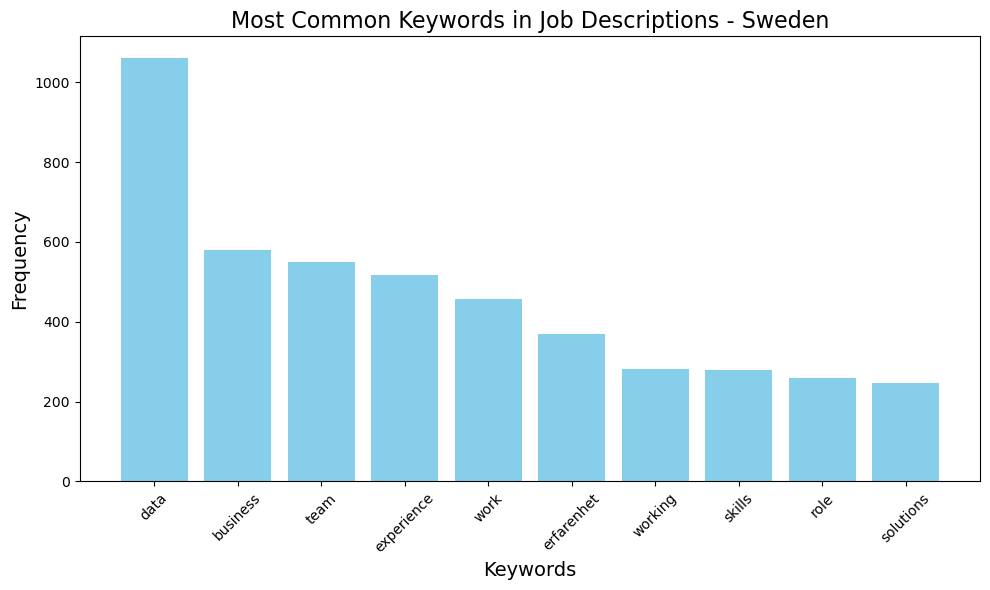

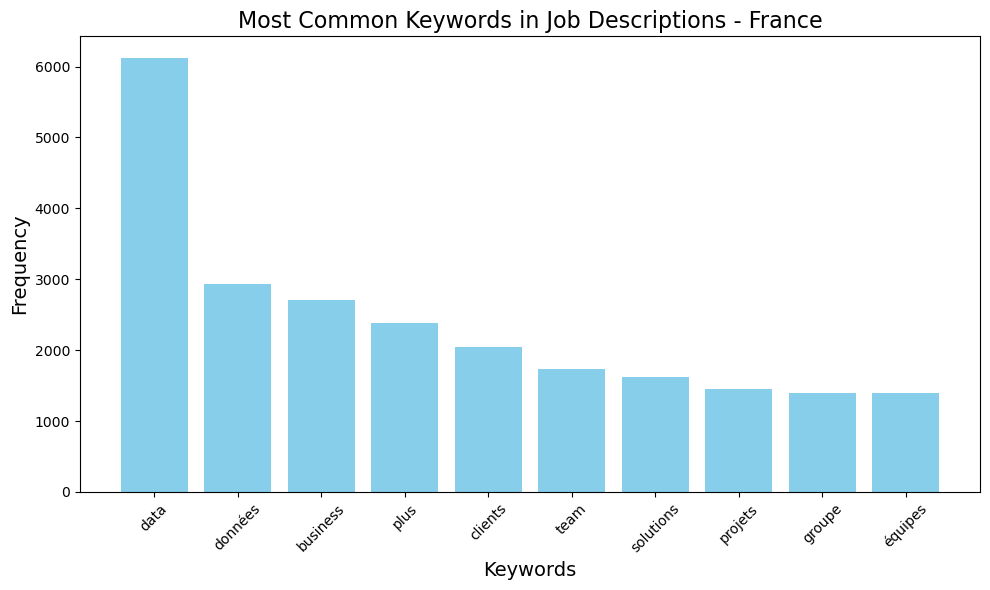

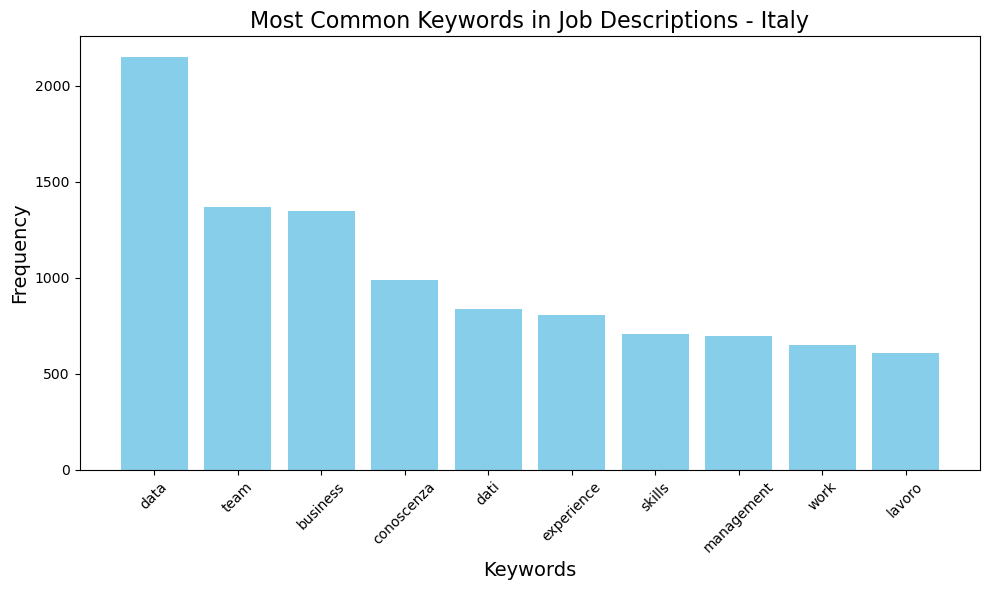

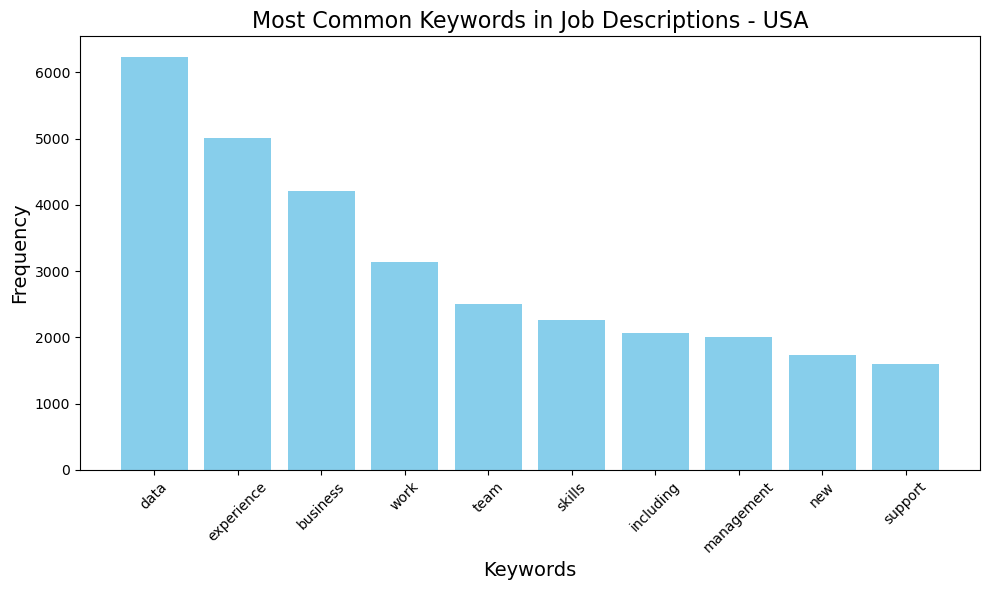

In [43]:
# Extract keywords 
common_keywords_SWE = extract_keywords(df_combined, 'Sweden', 'swedish')
common_keywords_FRA = extract_keywords(df_combined, 'France', 'french')
common_keywords_ITA = extract_keywords(df_combined, 'Italy', 'italian')
common_keywords_USA = extract_keywords(df_combined, 'USA', 'english')

# Plot common keywords 
plot_common_keywords(common_keywords_SWE[0], 'Sweden')
plot_common_keywords(common_keywords_FRA[0], 'France')
plot_common_keywords(common_keywords_ITA[0], 'Italy')
plot_common_keywords(common_keywords_USA[0], 'USA')

In [44]:
# Calculate software/programming keyword counts for each country 
keyword_counts_SWE = count_keywords(df_combined, 'Sweden')
keyword_counts_FRA = count_keywords(df_combined, 'France')
keyword_counts_ITA = count_keywords(df_combined, 'Italy')
keyword_counts_USA = count_keywords(df_combined, 'USA')

# Combine all dfs into one
keyword_counts_combined = pd.concat([keyword_counts_SWE, keyword_counts_FRA, keyword_counts_ITA, keyword_counts_USA], ignore_index=True)
keyword_counts_combined.sort_values(by=['Count'], ascending=[False])

,Category,Keyword,Search Keyword,Country,Count
333,Development Tools,git,Product Analyst,France,524
230,Data Analysis and Manipulation,excel,Product Analyst,France,461
275,Data Visualization and Business Intelligence (...,power bi,BI Analyst,France,357
331,Development Tools,git,Data Analyst,France,349
724,Data Analysis and Manipulation,excel,BI Analyst,USA,342
...,...,...,...,...,...
85,Development Tools,atom,Data Scientist,Sweden,1
523,Data Visualization and Business Intelligence (...,looker studio,Data Analyst,Italy,1
755,Data Visualization and Business Intelligence (...,looker studio,BI Analyst,USA,1
519,Data Visualization and Business Intelligence (...,looker,BI Analyst,Italy,1


In [55]:
# Extract interview information
interview_info_df, interview_flags_df = extract_interview_details(df_combined)

In [56]:
# Count the total occurrences of each interview stage
interview_flags_df = interview_flags_df.sum()
interview_flags_df

job_id               4598028
case_study                21
coding_assessment          7
phone_screening            6
on_site_interview          4
presentation             413
dtype: int64

In [58]:
# Are there tons of presentations?

# Create a DataFrame that includes 'job_id', 'job_title', and 'presentation_text'
presentation_df = interview_info_df[['job_id', 'presentation_text']]

# Drop rows where 'presentation_text' is None or NaN
presentation_df = presentation_df[presentation_df['presentation_text'].notna()]

# Find duplicates in 'presentation_text' and filter the DataFrame
presentation_duplicates = presentation_df[presentation_df['presentation_text'].duplicated(keep=False)]

In [47]:
# Print all non-null entries 

# Print duplicates along with their job IDs and job titles
if not presentation_duplicates.empty:
    print("Duplicate Presentation Texts with Job IDs and Job Titles:")
    print(presentation_duplicates)
else:
    print("No duplicates found in presentation texts.")


Duplicate Presentation Texts with Job IDs and Job Titles:
      job_id                                  presentation_text
181      182  ing the full spectrum of the bank's capabiliti...
198      199  alysis in business cases, product strategy, an...
207      208  alysis in business cases, product strategy, an...
841      842  ing the full spectrum of the bank's capabiliti...
862      863  a broad array of financing strategies that add...
864      865  Execution of small research projects, research...
960      961  ing exposure to client relationship management...
961      962  ing the full spectrum of the bank's capabiliti...
986      987  a broad array of financing strategies that add...
1019    1020  ing exposure to client relationship management...
1024    1025  rategies to address clients' specific needs   ...
1459    1460  tives from conception to execution in a cross-...
1715    1716  other technological platforms, ranging from mo...
1824    1825  ing exposure to client relations

In [48]:
# Are there duplicates? 
# Create a DataFrame that includes both 'job_id' and 'case_study_text'
case_study_df = interview_info_df[['job_id', 'case_study_text']]

# Find duplicates in 'case_study_text' and filter the DataFrame
duplicates = case_study_df[case_study_df['case_study_text'].notna()]

# Print duplicates along with their job IDs
if not duplicates.empty:
    print("Duplicate Case Study Texts with Job IDs:")
    print(duplicates)
else:
    print("No duplicates found in case study texts.")

Duplicate Case Study Texts with Job IDs:
      job_id                                    case_study_text
284      285  ruitment Process:     First interview (30 min)...
775      776  call with current analyst   First interview wi...
777      778  Our Hiring Process     Step 1: Recruiter Scree...
787      788  rocess works :   We examine your CV and cover ...
822      823  d.   Have an introduction call with Sabina, ou...
873      874  ,  the People Team calls you (30 min) to get t...
927      928  with the Talent Team (In English)   1:1 interv...
977      978  he recruitment process look like?          A f...
992      993  grams will close as positions are filled.   Th...
1149    1150  rstand your career expectations and answer you...
1157    1158  Rémi, Tech Recruiter (30 minutes)   A technica...
1180    1181  rstand your career expectations and answer you...
1281    1282  lorian, Senior Talent Acquisition Specialist (...
1367    1368  se your skills and learn more about our team. ...

In [49]:
# Check if these are duplicates (different links or job titles, for example) but they still have the same description. 
filtered_df = df_combined[df_combined['job_id'].isin(presentation_duplicates['job_id'])]
filtered_df

,job_id,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,salary_num,salary_num_low,salary_num_high,time_period,currency,min_salary_month,max_salary_month,date
181,182,3,Sweden,https://se.indeed.com/rc/clk?jk=d8b86a20e1c172...,Product Analyst,Stockholm,Investment Banking 2025 Analyst – Stockholm,Bank of America,Stockholm,Heltid,"Investment Banking 2025 Analyst Stockholm, S...",NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19
198,199,2,Sweden,https://se.indeed.com/rc/clk?jk=0fde1974e2824b...,Product Analyst,Göteborg,Business Support Analyst,Aurobay,417 55 Göteborg,nan,Aurobay has over hundred years of heritage i...,NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19
207,208,2,Sweden,https://se.indeed.com/rc/clk?jk=c5d51f6db70744...,Product Analyst,Göteborg,Business Support Analyst,Aurobay Sweden AB,Göteborg,"Tillsvidare, Heltid",Aurobay has over hundred years of heritage in ...,NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19
841,842,9,France,https://www.indeed.fr/rc/clk?jk=25de8e17119dca...,Product Analyst,Paris (75),Investment Banking 2025 Analyst – Paris,Bank of America,Paris (75),Temps plein,"Investment Banking 2025 Analyst Paris, Fran...",NaN,NaN,NaN,NaN,EUR,NaN,NaN,2024-09-20
862,863,11,France,https://www.indeed.fr/rc/clk?jk=ab62c4cc2b5bd8...,Product Analyst,Paris (75),Global Capital Markets Off-Cycle 2025 Analyst ...,Bank of America,Paris (75),Stage,"Global Capital Markets, Off-Cycle Analyst (DCM...",NaN,NaN,NaN,NaN,EUR,NaN,NaN,2024-09-20
864,865,11,France,https://www.indeed.fr/rc/clk?jk=2d40dee7766500...,Product Analyst,Paris (75),"Sales, Trading and Structuring Summer Internsh...",Barclays,75008 Paris,Stage,Summer Internship Programme Overview Join us ...,NaN,NaN,NaN,NaN,EUR,NaN,NaN,2024-09-20
960,961,20,France,https://www.indeed.fr/rc/clk?jk=004f9a54a69e48...,Product Analyst,Paris (75),Global Markets Sales and Trading Off-Cycle 202...,Bank of America,Paris (75),Stage,"Global Markets, Sales and Trading Off-cycle An...",NaN,NaN,NaN,NaN,EUR,NaN,NaN,2024-09-20
961,962,20,France,https://www.indeed.fr/rc/clk?jk=14b3afd98e65c2...,Product Analyst,Paris (75),Investment Banking Off-Cycle 2025 Analyst - Paris,Bank of America,Paris (75),Stage,"Investment Banking, Off-Cycle Analyst Paris...",NaN,NaN,NaN,NaN,EUR,NaN,NaN,2024-09-20
986,987,22,France,https://www.indeed.fr/rc/clk?jk=944b706927e452...,Product Analyst,Paris (75),Global Capital Markets Summer 2025 Analyst (DC...,Bank of America,Paris (75),Stage,"Global Capital Markets, Summer Analyst (DCM) ...",NaN,NaN,NaN,NaN,EUR,NaN,NaN,2024-09-20
1019,1020,25,France,https://www.indeed.fr/rc/clk?jk=83fb7110507660...,Product Analyst,Paris (75),Global Markets Sales and Trading Summer 2025 A...,Bank of America,Paris (75),Stage,"Global Markets Sales and Trading, Summer Analy...",NaN,NaN,NaN,NaN,EUR,NaN,NaN,2024-09-20


In [50]:
# Check if certain job_ids job descriptions are too similar 
pd.set_option('display.max_colwidth', 350)

# Specify the job IDs you're interested in
specific_job_ids = [3455, 3832, 3935] 

# Filter df_combined for rows where 'job_id' is in the specified list
filtered_df = df_combined[df_combined['job_id'].isin(specific_job_ids)]

# Print the job descriptions for these specific job IDs
print(filtered_df[['job_id', 'job_description']])

Empty DataFrame
Columns: [job_id, job_description]
Index: []


In [52]:
# Specify the job IDs you want to compare
job_id_1 = 1810
job_id_2 = 1847

# Filter the rows for these specific job IDs and select the column
description_1 = df_combined.loc[df_combined['job_id'] == job_id_1, 'job_description'].values[0]
description_2 = df_combined.loc[df_combined['job_id'] == job_id_2, 'job_description'].values[0]

# Compare the two values
if description_1 == description_2:
    print(f"The job descriptions for job IDs {job_id_1} and {job_id_2} are the same.")
else:
    print(f"The job descriptions for job IDs {job_id_1} and {job_id_2} are different.")


The job descriptions for job IDs 1810 and 1847 are different.


Information about the interview process seems to mostly be missing/left out from the job listnings. However, the most common category appears to be stages such as case studies, followed by phone screening, coding assessments, and presentations. 

If we look into what these steps includes we get, for example: 


## Univariate analysis 


In [ ]:
# histograms for salaries 
# to do 

## Bivariate analysis 

In [ ]:
# Word cloud visualizations per country
def plt_wordtree(data, country):
    #df = data['job_description']
    #country = 'France'
    # Combine all the text into a single string 
    text = ' '.join(data)
    # Create a wordcloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    # Display the wordcloud 
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Wordcloud of Job Descriptions - {country}')
    plt.axis('off')
    plt.show()

plt_wordtree(common_keywords_SWE[1], 'Sweden')
plt_wordtree(common_keywords_FRA[1], 'France')
plt_wordtree(common_keywords_ITA[1], 'Italy')
plt_wordtree(common_keywords_USA[1], 'USA')

In [ ]:
# Add also word cloud visualizations per job title? 

In [ ]:
# Box plots help visualize the distribution of salary ranges across different categories (e.g., job titles, countries).
# Look at outliers

# Number of job listings per job title and country 

In [ ]:
# Please note: salaries are not in the same currency so comparisons cant really be made 

sns.boxplot(data=df_combined, x='search_keyword', y='salary_num_low')
plt.xticks(rotation=45)
plt.title('Salary Distribution by Job Title')
plt.show()

mean_salary = df_combined.groupby('search_keyword')['salary_num_low'].mean().reset_index()
sns.barplot(data=mean_salary, x='search_keyword', y='salary_num_low')
plt.xticks(rotation=45)
plt.title('Average Salary by Job Title')
plt.show()

sns.countplot(data=df_combined, x='search_keyword', hue='salary_num_low')
plt.xticks(rotation=45)
plt.title('Count of Job Titles by Salary Range')
plt.show()

sns.countplot(data=df_combined, x='search_keyword', hue='country')
plt.xticks(rotation=45)
plt.title('Count of Job Titles by Country')
plt.show()

In [ ]:

import scipy.stats as stats

salary_ranges = pd.cut(df_combined['salary_num_low'], bins=[0, 20000, 40000, 60000, 80000, 100000], labels=['<20k', '20-40k', '40-60k', '60-80k', '80-100k'])
crosstab = pd.crosstab(df_combined['search_keyword'], salary_ranges)
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
print(f'Chi-squared: {chi2}, p-value: {p}')

In [ ]:
pivot_table = df_combined.pivot_table(values='salary_num_low', index='country', columns='search_keyword', aggfunc='mean')
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Average Salary Heatmap by Country and Job Title')
plt.show()

'''
g = sns.FacetGrid(df_clean, col='search_location', col_wrap=3)
g.map(sns.boxplot, 'search_keyword', 'salary_num_low')
plt.xticks(rotation=45)
plt.show()
'''

## Conclusions 
TBA.

- Job titles appear to vary somewhat between countries (since top 3 ones were different for different countries). 

Also interesting to look into 'Recruitment process' and 'Interview' process since there is data about that in the dataset?